In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA

import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'transfer_learn'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance
import numpy.random as npr
from tools_lnd import make_h_all, PC_axes, proximate_fp, calc_jacobian_at, get_model_params
from tools_lnd import make_dendro, gen_trials_from_model_dir, gen_X_from_model_dir, get_T_inds
from sklearn.decomposition import PCA
from sklearn import linear_model
from numpy import linalg as LA
from tools_lnd import get_D, make_h_trial_rule, get_model_params, plot_N, same_stim_trial, remove_spines

In [4]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v4_figs','paper_figs','fig5','pre_train_sets')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [12]:
m

'/Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/lr/data/LeakyRNN/softplus/diag/pro_small/15_tasks/256_n_rnn/lr7l2_w6_h6_fdgo_delaygo/post_train_delayanti/0'

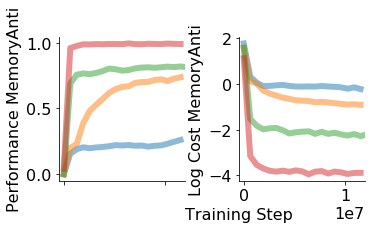

In [102]:
data_folder = 'code/multitask-nets/'+net+'/data/'
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'randgauss'
seed = '0'
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7
comp_at = 11360000

rules_dict = \
    {'all' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'], #15
    'mante' : ['contextdm1', 'contextdm2', 'multidm'], #3
    'delay' : ['fdgo', 'delaygo', 'fdanti', 'delayanti', 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm'], #9
    'memory' : ['delaygo', 'delayanti', 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm'], #7
    'react' : ['reactgo', 'reactanti', 'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'], #6
    'anti' : ['fdanti', 'reactanti', 'delayanti', 'dmsnogo', 'dmcnogo'], #5
    'match' : ['dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'], #4
    'category' : ['dmcgo', 'dmcnogo'], #2
    'delaypro_anti' : ['fdgo','fdanti'], #2
    'pro_big' : ['fdgo', 'reactgo', 'delaygo',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmcgo'], #10
    'mem_anti_motifs' : ['delaygo','fdanti'],
    'pro_small' : ['fdgo','delaygo'],
    'irrel_anti' : ['reactgo','dmcgo']} #2

rule_trains_set = {}
key_set =  ['pro_small','irrel_anti','pro_big','mem_anti_motifs',]
for key in key_set:
	rule_trains_set[key] = rules_dict[key]

rule_set_names = ['DelayGo', 'ReactGo', 'MemoryGo', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'DelayDecison1', 'DelayDecison2', 'ContextDelayDecison1', 'ContextDelayDecison2', 'MultiDelayDecison',
              'DM2SampleGo', 'DM2SampleNogo', 'DM2CategoryGo', 'DM2CategoryNoGo']

fig = plt.figure(figsize=(5, 2)) #7,2
plt.rcParams.update({'font.size': 16})
task_list = ['delayanti',]
ax_cost = fig.add_axes([.5,0,.35,1])#plt.subplot(2,2,1)
ax_perf = fig.add_axes([0,0,.35,1])

for rnn_type in ['LeakyRNN']: #'GRU',
    for activation in ['softplus']: #,'retanh','tanh'
        for init in ['diag']:# ,
            for seed in ['0']: #['untrained',]:

                for rule_trains_label in key_set:
                    rule_trains = rule_trains_set[rule_trains_label]

                    s = '_'
                    rule_trains_str = s.join(rule_trains)
                    post_train = 'delayanti'

                    # models_dir = os.path.join(p,'code/multitask-nets/stepnet/data/') #sherlock
                    models_dir = 'data/rnn/multitask/transfer_learn/lr' #compy
                    m = os.path.join(p,models_dir,rnn_type,activation,init,str(len(rule_trains))+'_tasks',
                                     str(n_rnn)+'_n_rnn','lr'+"{:.1f}".format(-lr)+
                                     'l2_w'+"{:.1f}".format(-l2w)+'_h'+
                                     "{:.1f}".format(-l2h)+'_'+rule_trains_str,'post_train_'+
                                     post_train,seed, 'log.json')
                    
                    with open(m, 'r') as f:
                        log_post = json.load(f)

                    early_comp = log_post['trials'][1]
        
                    plt.sca(ax_cost)
                    plt.plot(log_post['trials'],np.log(log_post['cost_'+post_train]),'-',
                             alpha = .5,linewidth = 6,label = rule_trains_label+' '+str(len(rule_trains))+'_tasks')
                    ax_cost.set_xlabel('Training Step')
                    ax_cost.xaxis.set_label_coords(0, -.18)
                    ax_cost.set_ylabel('Log Cost MemoryAnti')
                    plt.xlim([-500000,1.05*comp_at])

                    plt.sca(ax_perf)
                    plt.plot(log_post['trials'],log_post['perf_'+post_train],'-',
                             alpha = .5,linewidth = 6,label = rule_trains_label)
                    
                    ax_perf.set_xticklabels([])
                    ax_perf.set_ylabel('Performance MemoryAnti')
                    plt.xlim([-500000,1.05*comp_at]) 
                    ax_perf.spines['top'].set_visible(False)
                    ax_perf.spines['right'].set_visible(False)
                    ax_cost.spines['top'].set_visible(False)
                    ax_cost.spines['right'].set_visible(False)
                    plt.sca(ax_cost)

                    figname = 'cost_pretrain_sets'
                    plt.savefig(os.path.join(figpath,figname+'.pdf'),bbox_inches = 'tight')
                    plt.savefig(os.path.join(figpath,figname+'.png'),bbox_inches = 'tight')

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/lr/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/lr/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/lr/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/l

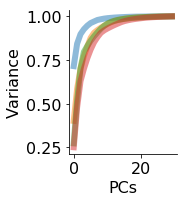

In [103]:
data_folder = 'code/multitask-nets/'+net+'/data/'
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'randgauss'
seed = '0'
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7
comp_at = 11360000

rules_dict = \
    {'all' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'], #15
    'mante' : ['contextdm1', 'contextdm2', 'multidm'], #3
    'delay' : ['fdgo', 'delaygo', 'fdanti', 'delayanti', 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm'], #9
    'memory' : ['delaygo', 'delayanti', 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm'], #7
    'react' : ['reactgo', 'reactanti', 'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'], #6
    'anti' : ['fdanti', 'reactanti', 'delayanti', 'dmsnogo', 'dmcnogo'], #5
    'match' : ['dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'], #4
    'category' : ['dmcgo', 'dmcnogo'], #2
    'delaypro_anti' : ['fdgo','fdanti'], #2
    'pro_big' : ['fdgo', 'reactgo', 'delaygo',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmcgo'], #10
    'mem_anti_motifs' : ['delaygo','fdanti'],
    'pro_small' : ['fdgo','delaygo'],
    'irrel_anti' : ['reactgo','dmcgo']} #2

rule_trains_set = {}
key_set =  ['pro_small','irrel_anti','pro_big','mem_anti_motifs',]
for key in key_set:
	rule_trains_set[key] = rules_dict[key]

rule_set_names = ['DelayGo', 'ReactGo', 'MemoryGo', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'DelayDecison1', 'DelayDecison2', 'ContextDelayDecison1', 'ContextDelayDecison2', 'MultiDelayDecison',
              'DM2SampleGo', 'DM2SampleNogo', 'DM2CategoryGo', 'DM2CategoryNoGo']

fig = plt.figure(figsize=(1.5, 2)) #7,2
plt.rcParams.update({'font.size': 16})
task_list = ['delayanti',]
ax = fig.add_axes([0,0,1,1])

for rnn_type in ['LeakyRNN']: #'GRU',
    for activation in ['softplus']: #,'retanh','tanh'
        for init in ['diag']:# ,
            for seed in ['0']: #['untrained',]:

                for rule_trains_label in key_set:
                    rule_trains = rule_trains_set[rule_trains_label]

                    s = '_'
                    rule_trains_str = s.join(rule_trains)
                    post_train = 'delayanti'

                    # models_dir = os.path.join(p,'code/multitask-nets/stepnet/data/') #sherlock
                    models_dir = 'data/rnn/multitask/transfer_learn/lr' #compy
                    m = os.path.join(p,models_dir,rnn_type,activation,init,str(len(rule_trains))+'_tasks',
                                     str(n_rnn)+'_n_rnn','lr'+"{:.1f}".format(-lr)+
                                     'l2_w'+"{:.1f}".format(-l2w)+'_h'+
                                     "{:.1f}".format(-l2h)+'_'+rule_trains_str,'post_train_'+
                                     post_train,seed)
                    
                    trial = gen_trials_from_model_dir(m,post_train,mode='random',noise_on = False,batch_size = 1000)
                    X, _ = gen_X_from_model_dir(m,trial)
                    pca = PCA(n_components = 30)
                    _ = pca.fit_transform(X.T)
                    
                    var = np.var(np.dot(pca.components_,X),axis = 1)
                    plt.plot(np.cumsum(var)/np.sum(var),'-',alpha = .5,linewidth = 6,label = rule_trains_label)
                    
                    ax.set_xlabel('PCs')
                    ax.set_ylabel('Variance')

                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)

                    figname = 'var'
                    plt.savefig(os.path.join(figpath,figname+'.pdf'),bbox_inches = 'tight')
                    plt.savefig(os.path.join(figpath,figname+'.png'),bbox_inches = 'tight')

In [82]:
def remove_ax_lines(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

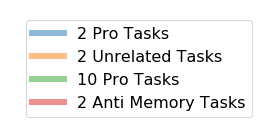

In [86]:
key_set =  ['2 Pro Tasks','2 Unrelated Tasks','10 Pro Tasks','2 Anti Memory Tasks',]

fig = plt.figure(figsize=(1, 1)) #7,2
plt.rcParams.update({'font.size': 16})
ax = fig.add_axes([0,0,.1,.1])

for x in range(len(key_set)):
    plt.plot(0,0,'-',alpha = .5,linewidth = 6,label = key_set[x])
    
remove_ax_lines(ax)
ax.set_xticks([])
ax.set_yticks([])
[x1,x2] = ax.get_xlim()
[y1,y2] = ax.get_ylim()
ax.set_ylim([1,2])
ax.set_xlim([1,2])
    
plt.legend(bbox_to_anchor=(1, -.25, 1, 1))
    
figname = 'pretrain_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)

    plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'pretrain_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()